In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [3]:
df=pd.read_csv("quora_dt.csv")
print("number of datapoints are ",df.shape[0])

number of datapoints are  404290


In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [7]:
df.groupby('is_duplicate').count()

,id,qid1,qid2,question1,question2
is_duplicate,,,,,
0,255027,255027,255027,255026,255025
1,149263,149263,149263,149263,149263


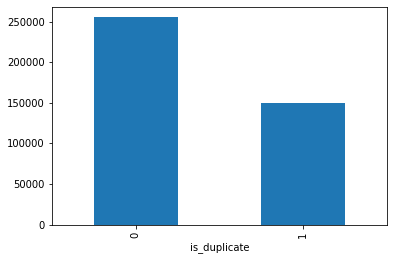

In [8]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [9]:
print("total number of questions for training:",len(df))
round(df['is_duplicate'].mean()*100,2)

total number of questions for training: 404290


36.92

In [10]:
print("total percentage of similar question pair available(is_duplicate=1) : '\n' {}% ".format(round(df['is_duplicate'].mean()*100,2)))
print("total percentage of dissimilar question pair available(is_duplicate=0) : '\n' {}% ".format(100-round(df['is_duplicate'].mean()*100,2)))

total percentage of similar question pair available(is_duplicate=1) : '
' 36.92% 
total percentage of dissimilar question pair available(is_duplicate=0) : '
' 63.08% 


In [11]:
#total number of unique questions

total_quest=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_quest=len(np.unique(total_quest))
print("Unique number of questions are: " , unique_quest)

#no of unique questions values occuring more than once

qids_more_once=np.sum(total_quest.value_counts()>1)
print("No of unique questions occuring more than once: {} ({}%) ".format(qids_more_once,qids_more_once/unique_quest*100))

#max number of times a question appears
print("Max number of times a question appears : {} ".format(max(total_quest.value_counts())))

                                                                   


Unique number of questions are:  537933
No of unique questions occuring more than once: 111780 (20.77953945937505%) 
Max number of times a question appears : 157 


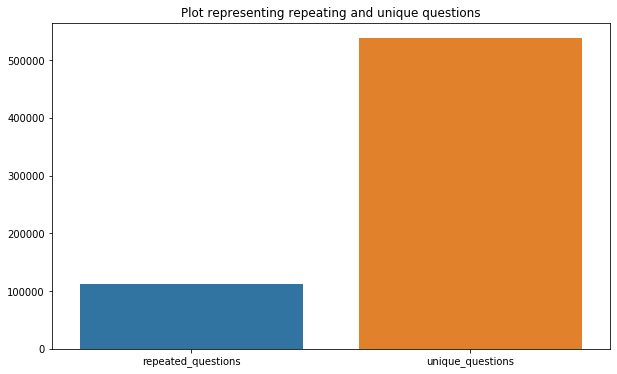

In [12]:
#plot between repeated and unique questions

x=["repeated_questions","unique_questions"]
y=[qids_more_once,unique_quest]

plt.figure(figsize=(10,6))
plt.title("Plot representing repeating and unique questions")
sns.barplot(x,y)
plt.show()

In [13]:
#checking for number of duplicates in the dataset i.e q1 q2 again in another row q1 q2
row_duplicates=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("number of duplicate rows in the dataset : {} ".format(row_duplicates.shape[0]-df.shape[0]))

number of duplicate rows in the dataset : 0 


Max number of times a question appears : 157 


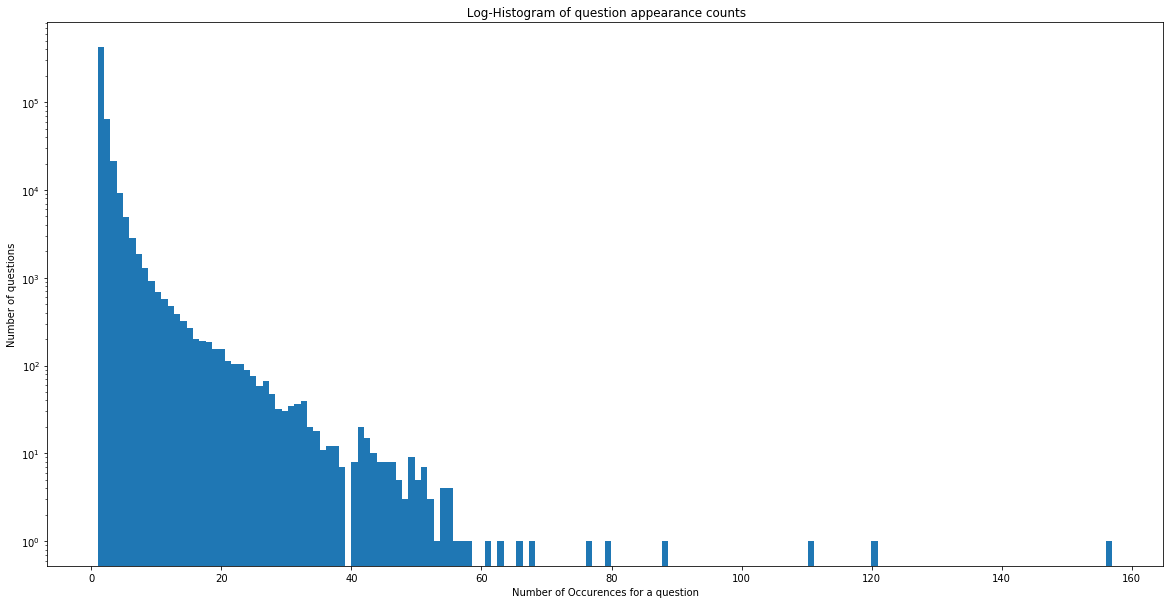

In [14]:
#Plot for Number of occurences for each question

plt.figure(figsize=(20,10))

plt.hist(total_quest.value_counts(),bins=160)

plt.yscale('log',nonposy='clip') #nonposx/nonposy: [‘mask’ | ‘clip’ ] non-positive values in x or y can be masked as invalid, or clipped to a very small positive number

plt.title(" Log-Histogram of question appearance counts")

plt.xlabel("Number of Occurences for a question")

plt.ylabel("Number of questions")

print("Max number of times a question appears : {} ".format(max(total_quest.value_counts())))




In [15]:
# None Values in some Rows of the dataset.Visualise it via df.info()

nan_rows=df[df.isnull().any(1)] #any(1) returns True if any element of an iterable is true
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [16]:
#filling the null values with ' '
df=df.fillna('')
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [17]:
#Basic Feature Extraction befor cleaning

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()
    

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [18]:
#Analysis of Extracted feature

print("minimum length of words in question1" ,min(df['q1_n_words']))

print("minimum length of words in question2" ,min(df['q2_n_words']))

print("Number of questions with minimum length in question1 is :", df[df['q1_n_words']==1].shape[0])

print("Number of questions with minimum length in question2 is :", df[df['q2_n_words']==1].shape[0])




minimum length of words in question1 1
minimum length of words in question2 1
Number of questions with minimum length in question1 is : 67
Number of questions with minimum length in question2 is : 24


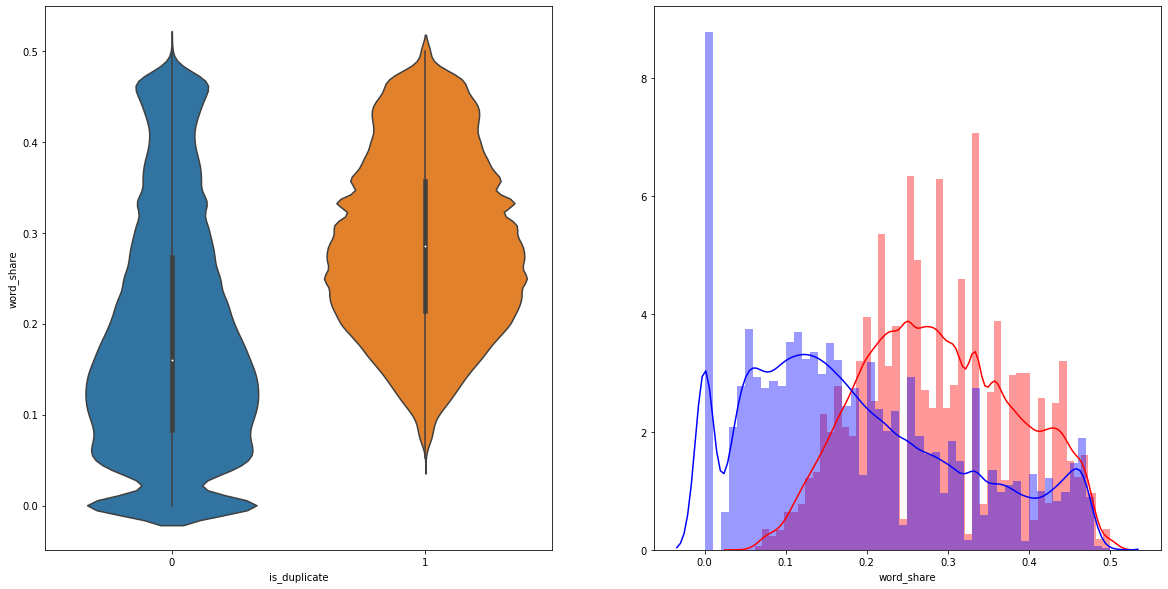

More the sharing in between 0 and 1 , more the duplicate.So Word share is a much better feature to analyze.


In [19]:
#Analysis on Feature word share

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_share'][0:],label="1",color='red')
sns.distplot(df[df['is_duplicate']==0.0]['word_share'][0:],label="0",color='blue')
plt.show()

print("More the sharing in between 0 and 1 , more the duplicate.So Word share is a much better feature to analyze.")

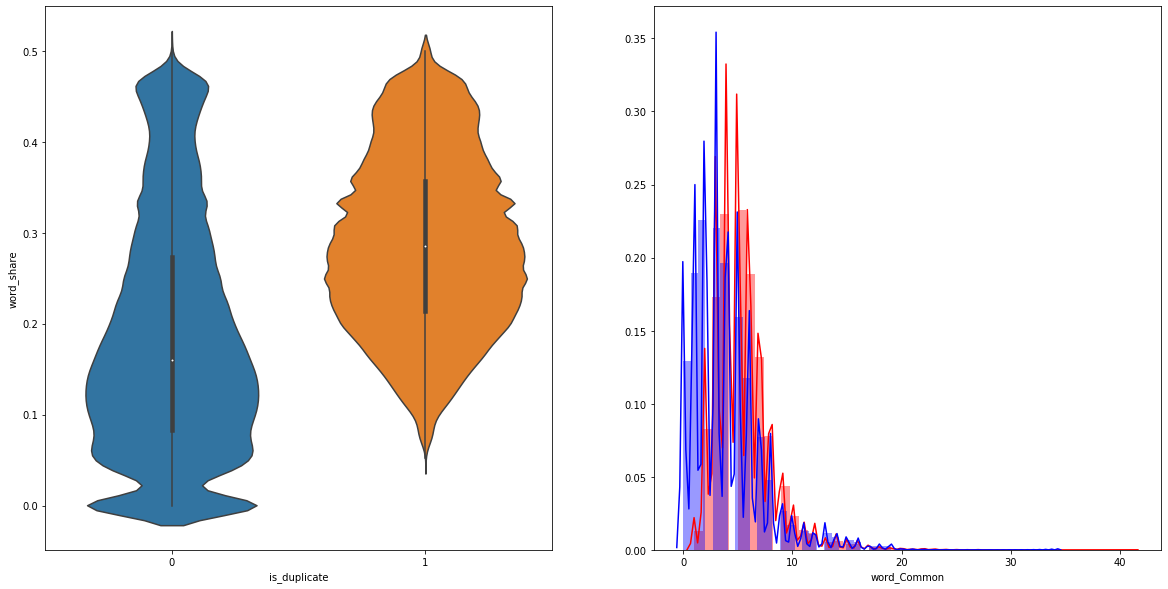

Highly overlapping in case of common words , so can't analyze much in a better way


In [20]:
#Analysis on Feature word share

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_Common'][0:],label="1",color='red')
sns.distplot(df[df['is_duplicate']==0.0]['word_Common'][0:],label="0",color='blue')
plt.show()

print("Highly overlapping in case of common words , so can't analyze much in a better way")

In [21]:
# To get the results in 4 decimal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

Advanced Pre processing of dataset

Token=Breaking of each sentence into each word 
Stop_word=Stop words as per NLTK
Word=A token that is not a Stop word

Features

cwc_min=Ratio of common word count to min length of word count of Q1 and Q2
cwc_min=common_word_count/min(len(q1_words),len(q2_words))

cwc_max=Ratio of common word count to max length of word count of q1 and q2
cwc_max=common_word_count/max(len(q1_words),len(q2_words))

csc_min=Ratio of common stop count to min length of word count of q1 and q2
csc_min=common_stop_count/min(len(q1_stops),len(q1_stops))

csc_max=Ratio of common stop count to max lenght of word count of q1 and q2
csc_max=common_stop_count/max(len(q1_stops),len(q1_stops))

ctc_min=Ratio of common token count to min length of word count of q1 and q2
ctc_min=common_token_count/min(len(q1_token),len(q2_token))

ctc_max=Ratio of common token count to max length of word count of q1 and q2
ctc_max=common_token_count/max(len(q1_token),len(q2_token))

last_word_eq=check if last word of question 1 is equal to last word of q2
last_word_eq=int(q1_token[-1]==q2_token[-1])

first_word_eq=checks whether first word of both questions are same or not
first_word_eq=int(q1_token[0]==q2_token[0])

abs_len_diff=length diff of q1_token and q2_token
abs_len_diff=abs(len(q1_token)-len(q2_token))

mean_len=mean of length of token words
mean_len=(len(q1_token)+len(q2_token))/2

fuzz_ratio
fuzz_partial_ratio
fuzz_sort_ratio
fuzz_set_ratio

longest_substr_Ratio=Ratio of length of longest common substring to min length of q1 and q2
longest_substr_Ratio=len(longest_substr_ratio)/min(len(q1_word),len(q2_word))


In [22]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [23]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [24]:
print("Extracting features for train:")
df = pd.read_csv("quora_dt.csv")
df = extract_features(df)
df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [25]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [26]:
# reading the text files and removing the Stop Words:

textp_w=open("train_p.txt","r",encoding='utf-8')
textp_w=textp_w.read()
textq_w=open("train_n.txt","r",encoding='utf-8')
textq_w=textq_w.read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textq_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


word cloud for duplicate question pairs


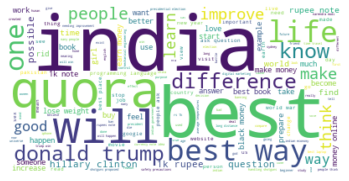

In [27]:
#Word cloud for duplicates questions

wc=WordCloud(background_color='white',max_words=len(textp_w))
wc.generate(textp_w)
print("word cloud for duplicate question pairs")
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

word cloud for non duplicate question pairs


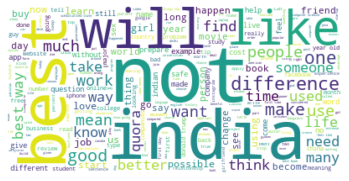

In [28]:
#word cloud on non duplicate words

wc=WordCloud(background_color='white',max_words=len(textq_w),stopwords=stopwords)
wc.generate(textq_w)
print("word cloud for non duplicate question pairs")
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

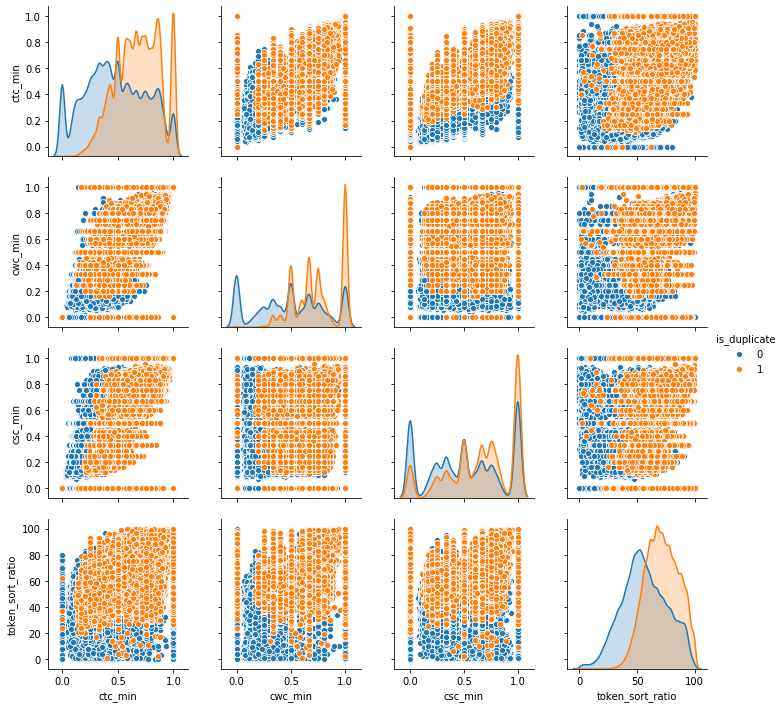

In [29]:
#generating pair plots(ctc_min,cwc_min,csc_min,token_sort_ratio)

n=df.shape[0]
sns.pairplot(df[['ctc_min','cwc_min','csc_min','token_sort_ratio','is_duplicate']][0:n],hue='is_duplicate',vars=['ctc_min','cwc_min','csc_min','token_sort_ratio'])
plt.show()

If we observe pdf of token sort features we could see that with label of 1 we have higher token_sort_ratio. It can be a good feature for distinguishing. So lets analyze token_sort_ratio


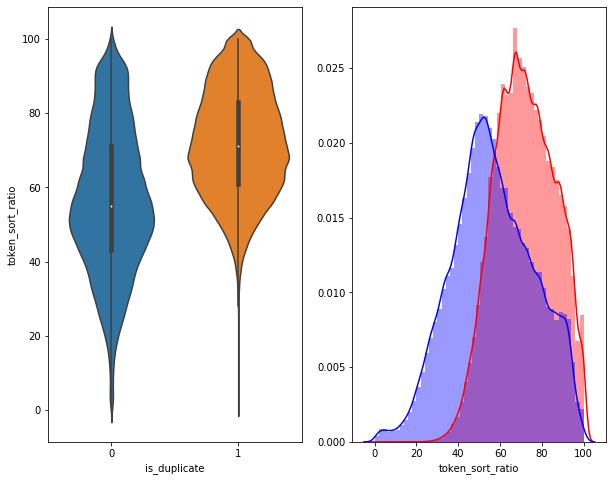

In [30]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

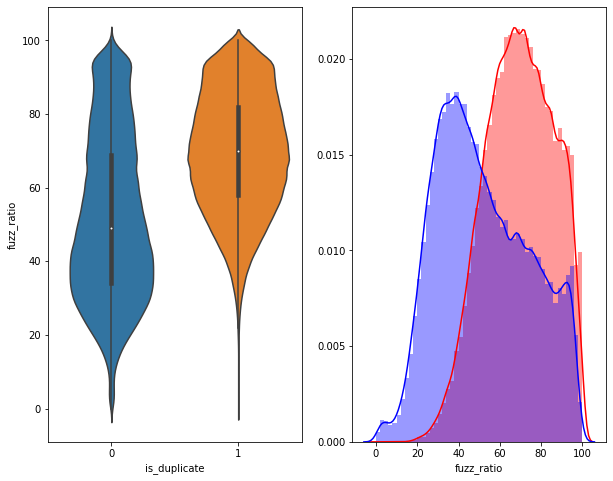

In [31]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [32]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [33]:
tsne2d=TSNE(
        n_components=2,
        init='random',
        random_state=101,
        method='barnes_hut',
        n_iter=1000,
        verbose=2,
        angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.081s...
[t-SNE] Computed neighbors for 5000 samples in 0.891s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.595s
[t-SNE] Iteration 50: error = 81.2911148, gradient norm = 0.0457501 (50 iterations in 6.594s)
[t-SNE] Iteration 100: error = 70.6044159, gradient norm = 0.0086692 (50 iterations in 4.452s)
[t-SNE] Iteration 150: error = 68.9124908, gradient norm = 0.0056016 (50 iterations in 4.106s)
[t-SNE] Iteration 200: error = 68.1010742, gradient norm = 0.0047585 (50 iterations in 4.226s)
[t-SNE] Iteration 250: error = 67.5907974, gradient norm = 0.0033576

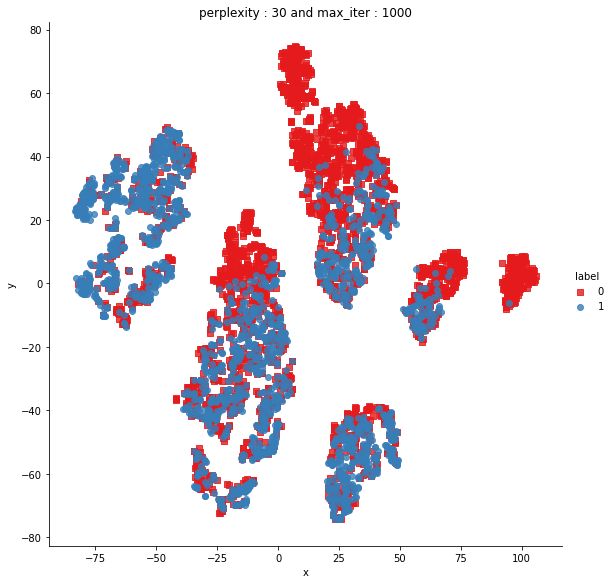

In [34]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [35]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.022s...
[t-SNE] Computed neighbors for 5000 samples in 0.752s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.473s
[t-SNE] Iteration 50: error = 80.5316772, gradient norm = 0.0296611 (50 iterations in 22.185s)
[t-SNE] Iteration 100: error = 69.3815765, gradient norm = 0.0033166 (50 iterations in 11.524s)
[t-SNE] Iteration 150: error = 67.9724655, gradient norm = 0.0018542 (50 iterations in 10.285s)
[t-SNE] Iteration 200: error = 67.4176865, gradient norm = 0.0012513 (50 iterations in 10.368s)
[t-SNE] Iteration 250: error = 67.1036377, gradient norm = 0.000

In [36]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [38]:
df=pd.read_csv('quora_dt.csv')
df['question1']=df['question1'].apply(lambda x:str(x))
df['question2']=df['question2'].apply(lambda x:str(x))


In [50]:
#merge texts
questions=list(df['question1'])+list(df['question2'])
tfidf=TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)
word2tfidf=dict(zip(tfidf.get_feature_names(),tfidf.idf_))

In [52]:
import spacy 
import en_core_web_sm
nlp = en_core_web_sm.load()

vecs1=[]
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df["question1"])):
    doc1=nlp(qu1)
    
    
    mean_vec1=np.zeros([len(doc1),len(doc1[0].vector)])
    for word1 in doc1:
        vec1=word1.vector
        #fetch df score
        try:
            idf=word2tfidf[str(word1)]
        except:
            idf=0
        #compute final vector
        mean_vec1+=vec1*idf
    mean_vec1=mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m']=list(vecs1)
    

100%|███████████████████████████████████████████████████████████████████████| 404290/404290 [1:03:57<00:00, 105.35it/s]


In [54]:
import spacy 
import en_core_web_sm
nlp = en_core_web_sm.load()

vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|█████████████████████████████████████████████████████████████████████████| 404290/404290 [50:03<00:00, 134.62it/s]


In [55]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [56]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [57]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [58]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [59]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,78.682992,87.635912,77.898819,-61.473692,44.053226,18.525178,-28.609312,47.452460,-86.095610,58.907952,...,7.157678,86.842601,38.238606,-25.909486,3.169638,-54.031532,-112.663659,1.619508,81.309565,-17.361949
1,99.993008,55.174564,-2.049167,36.677249,85.412371,-45.989080,31.112590,76.453094,-74.456509,110.348369,...,-64.475704,27.344039,-22.471263,-23.111044,-97.185489,13.815928,-24.577477,72.654378,58.654857,-19.836278
2,62.709638,72.489519,10.889310,-45.772860,71.261772,-34.385969,-26.228285,18.224490,-113.496336,115.968702,...,77.008272,5.414788,-26.222928,35.709896,-49.750098,-74.032807,-130.011004,-84.557644,10.153947,-30.314630
3,35.006791,-40.413219,53.450493,-45.069038,37.137247,-21.992808,-28.184323,131.916699,41.891510,27.243861,...,-36.975472,25.987250,-74.511655,-45.798322,42.739461,-17.318146,37.957786,-47.867102,-101.418604,-3.919247
4,135.425154,187.445625,143.612776,-111.735024,56.977977,-70.101866,-47.585533,59.575895,-56.992457,253.326808,...,-34.521699,74.533560,-3.963831,-77.077944,27.673524,-87.661703,-146.777092,1.730535,5.950078,-12.494797


In [60]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,69.938774,62.048677,65.471186,-65.080995,37.007811,11.953720,-44.908971,39.077935,-71.113359,64.970021,...,15.591466,96.113849,31.001480,-44.172052,21.397091,-46.908810,-100.162247,-1.978221,38.112752,-11.592531
1,100.523184,60.707327,114.135677,-2.311834,28.477254,-0.705671,113.688085,117.816506,-93.662698,81.227491,...,-84.838611,54.099417,-65.543286,-23.634332,-85.303453,33.143694,-65.774337,28.145018,-22.243213,0.169092
2,28.122773,-0.262905,-8.952834,-14.151883,18.908912,40.142980,62.036967,60.638759,-79.254361,108.044290,...,27.926253,33.117176,66.706154,50.397498,42.266215,-29.920099,-53.378103,-31.755547,77.061497,9.438696
3,22.605501,-22.139145,18.226516,-20.430915,22.291252,35.642941,-31.471534,61.818255,-40.677339,33.871990,...,-7.491278,44.788221,6.437781,39.981581,-43.237003,39.471643,-0.322382,-6.074735,-4.417220,5.627428
4,1.158371,29.232888,66.428352,-43.949273,12.497666,6.992168,-57.236839,32.344526,-56.251407,48.231540,...,44.084751,37.174410,0.356843,-29.468567,33.367771,-12.860933,-44.425541,3.958389,-13.291972,-9.029029


In [61]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [62]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')